<a href="https://colab.research.google.com/github/sagharrezanavaz/Linear-Algebra/blob/main/Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings

<p style="color: yellow">
It is highly recommended to use google colab for this notebook or else you need to download a dataset of size 386Mb and place it beside your local notebook. Also the last section benefits from GPU.</p>

Welcome to the second notebook of this assignment! Word embeddings are numerical representations of words. We can represent words as vectors and maintain their meaning. There are various ways of finding vecotrs for words, equivalently, word embeddings. We explore some of these techniques in this notebook.

In [ ]:
name = 'Saghar Rezanavaz'
student_id = 400103381

## Tabel of Contents

- 1- GloVe: Global Vectors for Word Representation
  - 1.1- Exploring word vectors (5 p)
  - 1.2- Visualizing in 2-D (10 p)
- 2- Evaluation
  - 2.1- Cosine similarity (5 p)
  - 2.2- A little test set (10 p)
- 3- Learn embeddings
  - 3.1- Dataset Preprocessing (10 p)
  - 3.1- Tokenization and Phrase Detection (5 p)
  - 3.3- Co-occurrence Matrix (15 p)
  - 3.4- SVD (5 p)
  - 3.5- Similarity (20 p)
- 4- Sentiment Analysis of MDB Movie Reviews
  - 4.1- Dataset (5 p)
  - 4.2- Model (10 p)
  - 4.3- Train (10 p)

## 1- GloVe: Global Vectors for Word Representation

GloVe (Global Vectors for Word Representation) is a pre-trained word embedding model developed by Stanford University. It is trained on large text corpora such as Wikipedia and Gigaword. The embeddings capture the semantic meaning of words, so words with similar meanings are represented by similar vectors in the embedding space.

The specific file `glove.6B.300d.txt` contains word vectors of size 300 (300-dimensional embeddings) trained on a dataset of 6 billion tokens from Wikipedia and Gigaword.

The vocabulary refers to the set of all words (or tokens) in the dataset for which embeddings are provided. Each word is represented as a dense vector of real numbers.

### 1.1- Exploring word vectors

According to the semantic meanings, what would be the values of $x, y, z, u, v$ and why?

|         | man   | woman | king  | queen | apple | orange |
| ---     | ---   | ---   |   --- | ---   | ---   |  ---   |
| gender  | -0.99 | 1     | -0.95 | 0.97  | u     | 0.01   |
| royalty | 0.01  | 0.02  | 0.93  | 0.95  | -0.01 | 0.00   |
| fruit   | 0.03  | x     | y     | z     | 0.94  | v      |

Note that we want the embeddings to capture semantic meanings such that $$man - woman \approx king - queen$$.

> YOUR ANSWER (0 or 1)

- x ≈ 0.0
- y ≈ 0.0
- z ≈ 0.0
- v ≈ 1.0
- u ≈ 0.0


In [ ]:
# run this code to install gensim on your environment
!pip install gensim

You can use the cell bellow to mount your drive with google colab. then after adding the dataset to your drive, you can access the dataset through colab. pay attention to unzip the dataset first.

link to dataset: https://drive.google.com/file/d/1amUx0ErSa3hsqiCdOQyDkO8uQBWz0uqD/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [ ]:

# unzip the dataset. you may need to modify the relative address based on the location of dataset in your drive.
!unzip drive/MyDrive/Colab\ Notebooks/glove.6B.300d.txt.zip

Archive:  drive/MyDrive/Colab Notebooks/glove.6B.300d.txt.zip
  inflating: glove.6B.300d.txt       


In [ ]:
model_path = "glove.6B.300d.txt"
print("Loading GloVe model from local file...")
model = KeyedVectors.load_word2vec_format(model_path, binary=False, no_header=True)
print("Model loaded!")

Loading GloVe model from local file...
Model loaded!


- **Vocabulary Size:** The size of the vocabulary is the number of unique words in the dataset.
- **Embedding Dimension:** This represents the length of the vector used to encode each word. For `glove.6B.300d.txt`, the dimension is 300.

Here are the key attributes of the loaded model.

- `index_to_key`
  - **Description:** A list of all the words (tokens) in the vocabulary in the order they were loaded.
  - **Example Usage:** To access the 10th word in the vocabulary:
      ```python
    model.index_to_key[9]

- `key_to_index`
  - **Description**: A dictionary mapping each word (token) to its corresponding index in the vocabulary.
  - **Example Usage**: To get the index of the word "king":
      ```python
      model.key_to_index["king"]
- `vectors`
  - **Description**: A NumPy array of shape (vocab_size, embedding_dim) where each row corresponds to the embedding of a word in the vocabulary.
  - **Example Usage**: To access the vector for the word "queen":
      ```python
      model["queen"]

- `get_vector(word)`
  - **Description**: A method to retrieve the embedding vector for a specific word.
  - **Example Usage:**
      ```python
      embedding_vector = model.get_vector("apple")

In [ ]:
def print_model_attributes(model):
    # Vocabulary size
    vocab_size = len(model.index_to_key)  # or len(model.key_to_index)

    # Embedding dimension
    embedding_dim = model.vector_size

    return vocab_size, embedding_dim

vocab_size, embedding_dim = print_model_attributes(model)
print(f"Vocab size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")

Vocab size: 400000
Embedding dimension: 300


### 1.2- Visualizing in 2-D

Use PCA and t-SNE for dimensionality reduction in [sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) for visualizing the embeddings for relationships like:

- tall $\rightarrow$ taller $\rightarrow$ tallest
- big $\rightarrow$ bigger $\rightarrow$ biggest

In [ ]:
def plot_embeddings_2d(model, words, method="PCA", perplexity=None, line_plot=None):
    # TODO: reduce the dimensionality of the embeddings to 2D using PCA or t-SNE. (≈6 lines)
    reduced_embeddings = None
# Extract embeddings for the given words
    try:
            embeddings = np.array([model[word] for word in words])
    except KeyError as e:
            print(f"Word not found in model: {e}")
            return

    # Reduce dimensions
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "tSNE":
        reducer = TSNE(n_components=2, perplexity=perplexity or 30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'PCA' or 't-SNE'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(6, 6))
    for i, word in enumerate(words):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y, color="blue", alpha=0.7)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)

    # Plot optional connections
    if line_plot:
        for (i, j) in line_plot:
            x1, y1 = reduced_embeddings[i]
            x2, y2 = reduced_embeddings[j]
            plt.plot([x1, x2], [y1, y2], color='red', linestyle='--')

    plt.title(f"Word Embeddings Visualization ({method})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()


In [ ]:
words = ["tall", "taller", "tallest", "big", "bigger", "biggest", "wide", "wider", "widest"]
line_plot = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8)]
words1 = ["smart", "smarter", "smartest", "wide", "wider", "widest", "small", "smaller", "smallest"]
line_plot1 = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8)]
words2 = ["man", "woman", "king", "queen", "boy", "girl", "husband", "wife"]
line_plot2 = [(0, 1), (2, 3), (4, 5), (6, 7)]

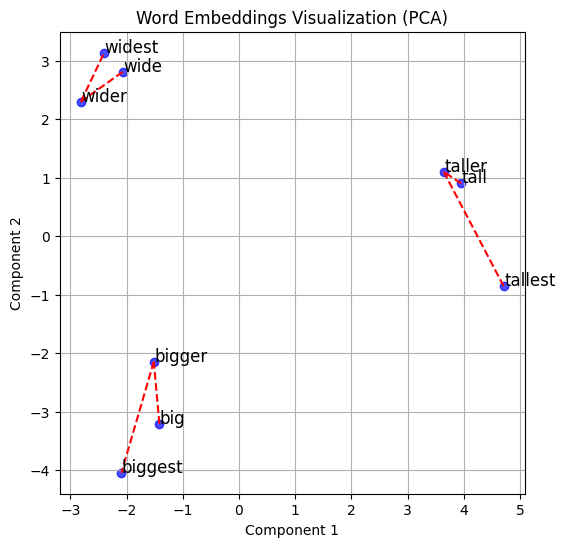

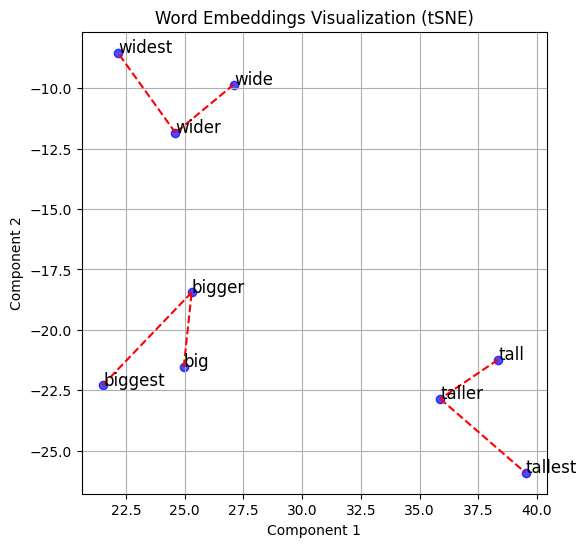

In [ ]:
plot_embeddings_2d(model, words, method="PCA", line_plot = line_plot)
plot_embeddings_2d(model, words, method="tSNE", perplexity = 3, line_plot = line_plot)

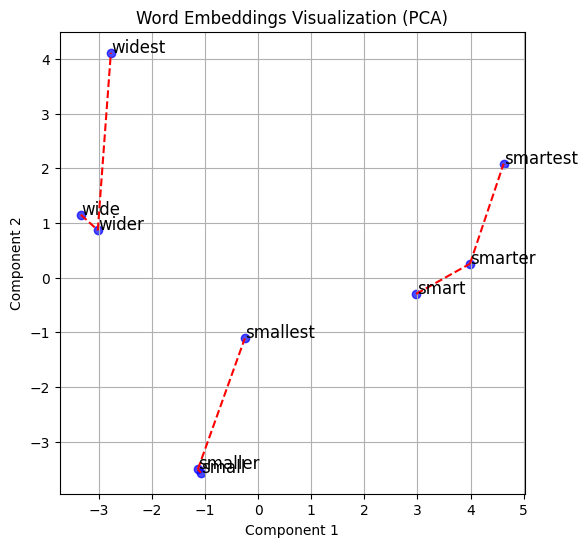

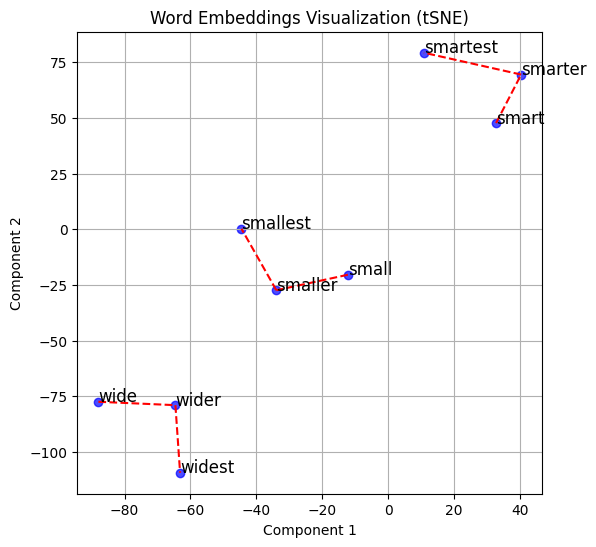

In [ ]:
plot_embeddings_2d(model, words1, method="PCA", line_plot = line_plot1)
plot_embeddings_2d(model, words1, method="tSNE", perplexity = 3, line_plot = line_plot1)

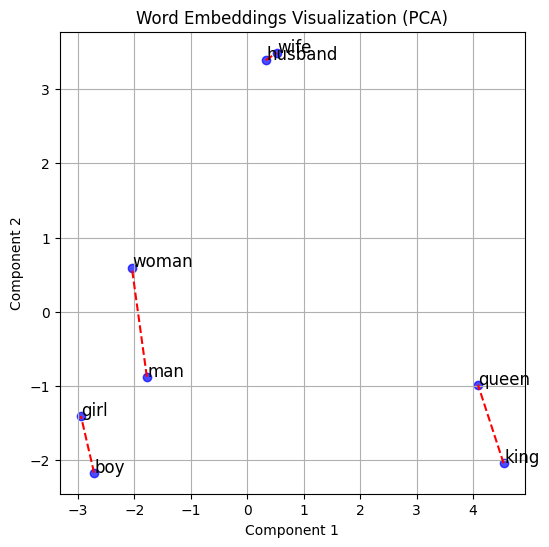

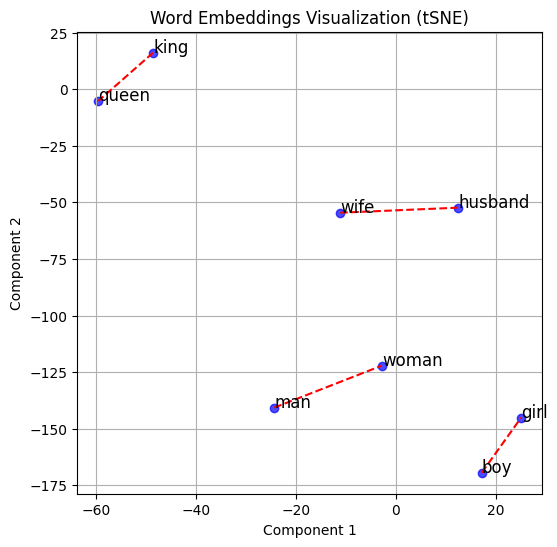

In [ ]:
plot_embeddings_2d(model, words2, method="PCA", line_plot = line_plot2)
plot_embeddings_2d(model, words2, method="tSNE", perplexity = 3, line_plot = line_plot2)

## 2- Evaluation

### 2.1- Cosine similarity

To evaluate the quality of word vectors, we should look at the similarity of word vectors that are semantically similar, for example word *France* is similar to *Italy*, so their word vectors should be similar. One common metric to measure the distance between word vectors is the **cosine similarity**. The cosine similarity between two words $w_x$ and $w_y$ is defined as
$$
cos(w_x, w_y) = \frac{w_x^Tw_y}{||w_x|| ||w_y||}
$$
, where $||.||$ is the $l_2$ norm.

In [ ]:
def cosine_similarity(u, v):
    # TODO: compute the cosine similarity between vectors u and v. (≈1 line)
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def find_most_similar(word, model, top_n=5):
    # TODO: find the top_n most similar words to the given word. (≈4 lines)
    if word not in model:
        raise ValueError(f"Word '{word}' not in the model vocabulary.")
    # Retrieve word vector for the given word
    word_vector = model[word]

    # Compute cosine similarity with all words in the model
    similarities = [(other_word, cosine_similarity(word_vector, model[other_word]))
                    for other_word in model.index_to_key if other_word != word]

    # Sort by similarity in descending order and return top_n
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]

# TODO: find the cosine similarity between the vectors of "france" and "tehran". (≈1 line)
similarity_france_tehran = cosine_similarity(model["france"], model["tehran"])
print(f"Cosine similarity between 'france' and 'tehran': {similarity_france_tehran}")

# TODO: same as above for "france" and "paris". (≈1 line)
similarity_france_paris = cosine_similarity(model["france"], model["paris"])
print(f"Cosine similarity between 'france' and 'paris': {similarity_france_paris}")

# TODO: find the top 5 most similar words to "france". (≈1 line)
most_similar_to_france = find_most_similar("france", model, top_n=5)
print("Top 5 most similar words to 'france':")
for word, similarity in most_similar_to_france:
    print(f"{word}: {similarity:.4f}")


Cosine similarity between 'france' and 'tehran': 0.24860085546970367
Cosine similarity between 'france' and 'paris': 0.6580672860145569
Top 5 most similar words to 'france':
french: 0.7345
paris: 0.6581
belgium: 0.6207
spain: 0.5736
italy: 0.5643


### 2.2- A little test set

One evaluation approach that was introduced in [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781) is to consider two pairs of words that have the same type of relationship, for example, *big - bigger* and *small - smaller*. Each two pairs can be viewed as a question: ”What is the word that is similar to small in the same sense as bigger is similar to big?”.

Interestingly, these questions can be answered by doing basic algebraic operations on the word vectors. First we compute $$x = w_{bigger}-w_{big}+w_{small}$$, and then search through all possible word vectors to find the closest one to $x$. In this notebook we use cosine similarity to measure closeness. So the problem can be written as $$ w^{*} = \arg\max_{w} cos(w, w_{bigger}-w_{big}+w_{small}) $$.

In [ ]:
test_set = [
    ["paris", "france", "toronto", "canada"],
    ["australia", "dollar", "japan", "yen"],
    ["chicago", "illinois", "stockton", "california"],
    ["brother", "sister", "father", "mother"],
    ["apparent", "apparently", "rapid", "rapidly"],
    ["possibly", "impossibly", "ethical", "ethically"],
    ["great", "greater", "tough", "tougher"],
    ["easy", "easiest", "lucky", "luckiest"],
    ["think", "thinking", "read", "reading"],
    ["switzerland", "swiss", "turkey", "turkish"],
    ["walking", "walked", "swimming", "swam"],
    ["mouse", "mice", "dollar", "dollars"],
    ["work", "works", "speak", "speaks"],
]
def analogy(model, words):
    a, b, c, expected = words  # A is to B as C is to ?

    if a not in model or b not in model or c not in model:
        return None, 0

    analogy_vector = model[b] - model[a] + model[c]

    similar_words = model.similar_by_vector(analogy_vector, topn=1)

    # Find the best match
    for word, score in similar_words:
            return word, score



# def analogy(model, words):
#     """
#     Find the word that completes the analogy: a is to b as c is to d.

#     Args:
#         model (KeyedVectors): Pre-trained word embedding model.
#         words (list of str): List of 4 words [a, b, c, d], where we predict d.

#     Returns:
#         tuple: (best_word, best_score) - the word that best completes the analogy and its similarity score.
#     """
#     a, b, c, d = words
#     a=a.lower()
#     b=b.lower()
#     c=c.lower()
#     d=d.lower()
#     if any(word not in model for word in words[:3]):
#         raise ValueError(f"One or more words in {words[:3]} are not in the model vocabulary.")

#     # Compute the vector: x = w_b - w_a + w_c
#     x = model[b] - model[a] + model[c]

#     # Find the word with the highest cosine similarity to x, excluding the input words
#     best_word = None
#     best_score = -1
#     for word in model.index_to_key:
#         if word in words:  # Skip input words
#             continue
#         similarity = cosine_similarity(x, model[word])
#         if similarity > best_score:
#             best_word = word
#             best_score = similarity

#     return best_word, best_score

def evaluate_analogy(model, test_set):
    """
    Evaluate the model on the analogy task.

    Args:
        model (KeyedVectors): Pre-trained word embedding model.
        test_set (list of list of str): List of analogy test cases. Each case is a list [a, b, c, d].

    Returns:
        float: Accuracy of the model on the test set.
    """
    correct = 0
    for words in test_set:
        predicted_word, _ = analogy(model, words)
        print(predicted_word,words[3])
        if predicted_word == words[3]:  # Check if the predicted word matches the expected word
            correct += 1

    return correct / len(test_set)

accuracy = evaluate_analogy(model, test_set)
print(f"Accuracy: {accuracy}")


toronto canada
dollar yen
stockton california
sister mother
rapid rapidly
ethical ethically
tougher tougher
lucky luckiest
read reading
turkish turkish
swimming swam
dollar dollars
speak speaks
Accuracy: 0.15384615384615385


## 3- Learn embeddings

This part goes through the process of cleaning a dataset, visualizing tokens, creating word embeddings using a co-occurrence matrix, and applying Singular Value Decomposition (SVD) to reduce dimensionality.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
import re
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

from gensim.models.phrases import Phrases, Phraser
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

### 3.1- Dataset Preprocessing

In this section, we will:

1. Load the Simpsons dataset.
2. Clean the text data by removing stop words, lemmatizing words, and filtering tokens.
3. Visualize the top tokens using a WordCloud.

In [ ]:
root_path = '/content/drive/My Drive/Colab Notebooks'
# Change this to the root path of your dataset
df = pd.read_csv(f'{root_path}/simpsons_dataset.csv')
print(f"Initial Dataset Shape: {df.shape}")
df

Initial Dataset Shape: (158314, 2)


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
158309,Miss Hoover,I'm back.
158310,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
158311,Miss Hoover,Psy-cho-so-ma-tic.
158312,Ralph Wiggum,Does that mean you were crazy?


In [ ]:
df.isnull().sum()

,0
raw_character_text,17814
spoken_words,26459


In [ ]:
# TODO: drop the rows with missing values. (≈1 line)
df.dropna(inplace=True, axis=0)
print(f"Dataset Shape after Dropping NaNs: {df.shape}")

Dataset Shape after Dropping NaNs: (131853, 2)


**Removing Stop Words in NLP Using NLTK:** Stop words are common words like "and," "the," or "is" that add little value to text analysis. In NLP, we use tools like NLTK to remove these words and focus on meaningful terms for better accuracy in tasks like sentiment analysis and classification.

For example consider this text:

*The quick brown fox jumps over the lazy dog.*

After removing stop words `["the", "over"]`, we get:

*quick brown fox jumps lazy dog.*

By eliminating stop words, the processed text becomes more concise and meaningful for analysis.

In the cell below, download the NLTK stopwords and WordNet modules. You can also add custom stopwords.

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
print(len(stop_words)
)# Add custom stop words
stop_words.update([
    "i'm", "i'll", "this'll", "what'l", "that's", "he", "he'd", "she", "she'd",
    "it", "they", "him", "her", "his", "their", "but", "for", "nor", "so",
    "with", "by", "be", "have", "do", "can", "will", "may", "very", "really",
    "just", "then", "now", "there", "where", "how", "like", "uh", "um",
    "you know", "oh", "well",
    "that", "these", "those", "each", "every", "some", "any", "all",
    "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "much", "many", "more", "most", "less", "least",
    "same", "other", "another", "which", "whoever", "whomever",
    "whichever", "whatsoever", "could", "would", "should", "might",
    "must", "shall", "can", "may", "if", "as", "than", "while",
    "because", "although", "since", "unless", "whereas", "before",
    "after", "during", "while", "about", "along", "among", "but",
    "yet", "for", "nor", "so", "either", "neither", "whether",
    "instead", "regarding", "despite", "although", "not", "never",
    "ever", "just", "really", "very", "quite", "too", "still",
    "yet", "also", "especially", "particularly", "simply",
    "actually", "literally", "essentially", "virtually", "truly",
    "specially", "in fact", "on the other hand", "in addition",
    "meanwhile", "however", "therefore", "furthermore", "likewise",
    "consequently", "subsequently", "additionally", "moreover",
    "notably", "here", "there", "when", "where", "what", "why","aw","oooh",
    "who", "whom", "whose", "which", "how", "a", "an", "the","who's",
])
print(len([
    "i'm", "i'll", "this'll", "what'l", "that's", "he", "he'd", "she", "she'd",
    "it", "they", "him", "her", "his", "their", "but", "for", "nor", "so",
    "with", "by", "be", "have", "do", "can", "will", "may", "very", "really",
    "just", "then", "now", "there", "where", "how", "like", "uh", "um",
    "you know", "oh", "well",
    "that", "these", "those", "each", "every", "some", "any", "all",
    "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "much", "many", "more", "most", "less", "least",
    "same", "other", "another", "which", "whoever", "whomever",
    "whichever", "whatsoever", "could", "would", "should", "might",
    "must", "shall", "can", "may", "if", "as", "than", "while",
    "because", "although", "since", "unless", "whereas", "before",
    "after", "during", "while", "about", "along", "among", "but",
    "yet", "for", "nor", "so", "either", "neither", "whether",
    "instead", "regarding", "despite", "although", "not", "never",
    "ever", "just", "really", "very", "quite", "too", "still",
    "yet", "also", "especially", "particularly", "simply",
    "actually", "literally", "essentially", "virtually", "truly",
    "specially", "in fact", "on the other hand", "in addition",
    "meanwhile", "however", "therefore", "furthermore", "likewise",
    "consequently", "subsequently", "additionally", "moreover",
    "notably", "here", "there", "when", "where", "what", "why","aw","oooh",
    "who", "whom", "whose", "which", "how", "a", "an", "the","who's",
]))
print(stop_words)
print(len(stop_words)
)

179
159
{'the', 'three', 'eight', 'about', "who's", 'she', 'm', "weren't", 'until', 'and', 'me', 'in addition', 'itself', 'we', 'moreover', 'being', "haven't", 'especially', 'much', 'must', 'although', 'therefore', 'yet', 'in fact', 'by', 'over', 'am', 'really', 'each', "shan't", 'for', 'all', 'whereas', 'among', 'still', 'ain', 'where', 'this', 'another', "it's", 'likewise', 'yourself', 'on the other hand', 'they', 'these', 'her', 'be', 'a', 'aren', 'more', 'um', 'whatsoever', 'into', 'from', 'were', 'no', 'or', "should've", 'needn', 'hers', 'down', 't', 'instead', 'theirs', 'ten', 'isn', 's', 'when', "that's", 'above', 'once', 'those', 'wouldn', 'you', 'would', 'been', 'won', 'particularly', 'truly', 'what', 'specially', 'themselves', 'along', 'why', 'it', 'your', 'four', 'both', 'couldn', 'before', 'essentially', 'haven', 'll', 'shan', 'does', 'on', 'either', 'if', 'are', 'under', 'very', 'since', "aren't", 'that', 'd', 'him', 'least', "you're", 'ourselves', 'o', "hadn't", 'might', 

The `WordNetLemmatizer` is a tool provided by NLTK that reduces words to their base or root form, known as the **lemma**, while ensuring the word remains meaningful in context. **Lemmatization** uses linguistic rules and a vocabulary (WordNet) to produce valid dictionary words.
For example:
- `"running"` becomes `"run"`  
- `"better"` becomes `"good"`  

The `clean_text` function preprocesses input text to prepare it for NLP tasks by performing the following steps:

1. **Remove Non-Alphabetic Characters**:  
   Removes characters that aren't letters to clean the text like punctuation and numbers.

2. **Lowercase Conversion**:
   Converts all letters to lowercase for uniformity.

3. **Tokenization and Stop Word Removal**:  
   Breaks the text into individual words (in this case **tokens**) and removes common stop words to focus on meaningful terms.  

4. **Lemmatization**:  
   Converts each word to its root form using the `WordNetLemmatizer` for better consistency in analysis.  

After this preprocesses we have:

- Input: `"The running dogs quickly jumped over fences!"`  
- Output: `"run dog quick jump fence"`  

The function ensures the text is simplified and meaningful, helping improve the performance of NLP tasks such as text classification or sentiment analysis. If the cleaned text has fewer than three words, it skips the text.

In [ ]:
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
# def clean_text(text):
#     """Cleans input text by removing non-alphabetic characters,
#     lowercasing, removing stopwords, and lemmatizing."""

#     # Remove unwanted punctuation but keep apostrophes and convert to lowercase
#     cleaned_text = re.sub(r"[^\w\s']", '', text).lower()  # Allow letters, apostrophes, and spaces

#     # Keep the contraction intact, tokenize into words
#     tokens = word_tokenize(cleaned_text)

#     # Remove stop words and apply lemmatization
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

#     # Return cleaned text if it has more than 2 tokens
#     return ' '.join(lemmatized_tokens).strip() if len(lemmatized_tokens) > 2 else ""

# # Example usage
# text_example = "Where's Mr. Bergstrom?"
# cleaned_example = clean_text(text_example)
# print(cleaned_example)  # Expected output: "where's mr bergstrom"
def clean_text(text):
    """Cleans input text by removing non-alphabetic characters,
     lowercasing, removing stopwords, and lemmatizing."""

    # Remove non-alphabetic characters and convert to lowercase

    # Tokenize and remove stop words, apply lemmatization
    # Tokenize by splitting on whitespace (instead of word_tokenize)
    # Tokenize by splitting on whitespace
    tokens = text.lower()
    tokens = re.split(r"[\s-]+", tokens)  # This ensures splitting on both space and hyphen

    tokens = [re.sub(r"[^a-zA-Z0-9']", "", word) for word in tokens]


    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word).lower() for word in tokens if word.lower() not in stop_words]

    # Remove non-alphanumeric characters after lemmatization (except apostrophes)

    # Remove empty strings and return cleaned text if it has more than 2 tokens
    tokens = [word for word in tokens if word]

    return " ".join(tokens).strip() if len(tokens) > 2 else ""

# Example usage
text = "Good morning, Lisa."
print(clean_text(text))

good morning lisa


In [ ]:
# TODO: Apply cleaning and save the result in another columns spoken_words_clean (≈1 line)
# df.drop(columns=['raw_character_text'],inplace=True)
df['spoken_words_clean'] = df['spoken_words'].apply(clean_text)
# print(df.loc[df['spoken_words'] == "Good morning, Lisa.", 'spoken_words_clean'])


After cleaning some values might become NaN, remove them. Then Display cleaned dataframe.

In [ ]:
# TODO: Drop NaN values and duplicates after cleaning (≈1 line)
df_clean = df.drop_duplicates(subset=['spoken_words_clean'])
df_clean.dropna(inplace=True)
df_clean = df_clean.rename(columns={'spoken_words_clean': 'clean'})

df_clean.drop(columns=['raw_character_text'],inplace=True)
print(f"Cleaned Dataset Shape: {df_clean.shape}")
df_clean

Cleaned Dataset Shape: (90130, 2)


<ipython-input-23-787ec61d08ab>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,spoken_words,clean
0,"No, actually, it was a little of both. Sometim...",little sometimes disease magazine news show na...
1,Where's Mr. Bergstrom?,where's mr bergstrom
2,I don't know. Although I'd sure like to talk t...,know i'd sure talk touch lesson plan teach
3,That life is worth living.,life worth living
4,The polls will be open from now until the end ...,poll open end recess case decided put thought ...
...,...,...
158293,Can I get my ears pierced?,get ear pierced
158295,Can I dye my shoes pink?,dye shoe pink
158307,"Mr. Bergstrom, we request the pleasure of your...",mr bergstrom request pleasure company mr bergs...
158310,"You see, class, my Lyme disease turned out to ...",see class lyme disease turned


In [ ]:
sample_examples = df_clean.sample(5, random_state=8)

print("=== Sample Cleaning Examples ===\n")

for index, row in sample_examples.iterrows():
    print(f"Example {index + 1}:")
    print(f"------------------")
    print(f"Original: {row['spoken_words']}")
    print(f"Cleaned:  {row['clean']}")
    print(f"------------------\n")

print("===============================")

=== Sample Cleaning Examples ===

Example 489:
------------------
Original: Sorry, Fallout Boy, not until you're sixteen.
Cleaned:  sorry fallout boy sixteen
------------------

Example 13627:
------------------
Original: Knock that off, you two. It's time for church!
Cleaned:  knock time church
------------------

Example 39726:
------------------
Original: Marge, why don't you let me handle this?
Cleaned:  marge let handle
------------------

Example 66596:
------------------
Original: Let's just float by quietly...
Cleaned:  let's float quietly
------------------

Example 18637:
------------------
Original: Toby Hunter, Minneapolis Star. No, really. Is this a joke?
Cleaned:  toby hunter minneapolis star joke
------------------



To continue, let's only keep the preprocessed texts.

In [ ]:
df_clean = df_clean.drop(columns=['spoken_words'])
df_clean

,clean
0,little sometimes disease magazine news show na...
1,where's mr bergstrom
2,know i'd sure talk touch lesson plan teach
3,life worth living
4,poll open end recess case decided put thought ...
...,...
158293,get ear pierced
158295,dye shoe pink
158307,mr bergstrom request pleasure company mr bergs...
158310,see class lyme disease turned


The **`WordCloud`** library in Python is used to create visual representations of text data, where word size reflects its frequency or importance. It offers customizable options like background color, dimensions, and stop word filtering, making it a powerful tool for quickly analyzing text patterns.

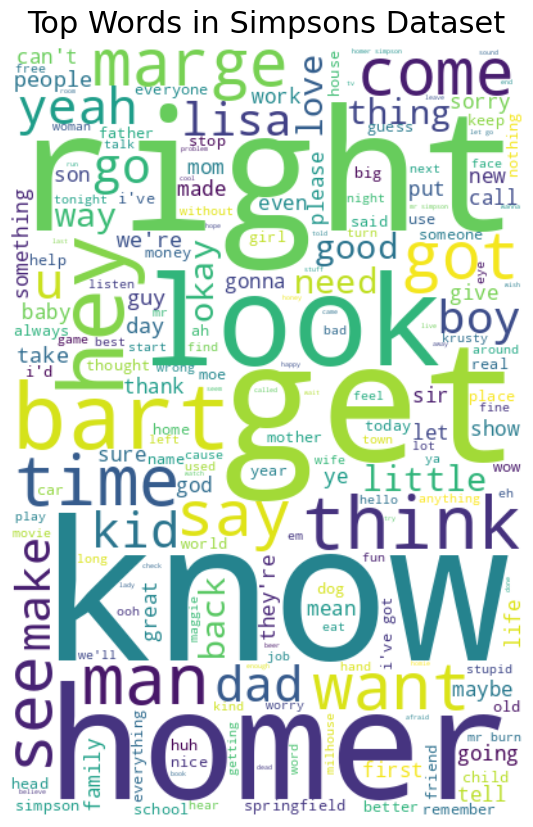

In [ ]:
# TODO: Combine all cleaned texts into a single string (≈1 line)
text = ' '.join(df_clean['clean'].astype(str).tolist())

wc = WordCloud(
    background_color='white',
    stopwords=stop_words,
    max_words=200,
    height=600,
    width=400,
).generate(text)

plt.figure(figsize=(18, 10))
plt.title('Top Words in Simpsons Dataset', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3.2- Tokenization and Phrase Detection

In this section, we will tokenize cleaned sentences and use the Gensim Phrases and Phraser tools to detect common bigrams in the text.

Tokenization is the process of splitting text into individual words or tokens. In this case, we will split each sentence in `df_clean['clean']` into a list of words, preparing the text for further analysis, such as phrase detection.

**Original Sentence:**  
```python
The quick brown fox jumps over the lazy dog.
```

**Tokenized Output:**  
```python
['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
```

This step transforms the text into a format that is easier to work with in subsequent analyses.

In [ ]:
# TODO: Tokenize sentences (≈1 line)
print(df_clean['clean'] [:2])
sentences = df_clean['clean'].apply(lambda x: x.split()).tolist()
sentences[:2]

0    little sometimes disease magazine news show na...
1                                 where's mr bergstrom
Name: clean, dtype: object


[['little',
  'sometimes',
  'disease',
  'magazine',
  'news',
  'show',
  'natural',
  'think'],
 ["where's", 'mr', 'bergstrom']]

In this part, we perform two key tasks: detecting common **bigrams** (pairs of words) in the text and calculating the **frequency** of each word, including bigrams, in the dataset.

The `Phrases` tool from Gensim is used to detect common bigrams in the tokenized sentences. The `min_count ` argument ensures that only bigrams appearing at least five times are considered, and `threshold ` filters out less significant bigrams. The `Phraser` tool speeds up the transformation by creating a more efficient bigram model.

The model is applied to the tokenized sentences, enriching the text with detected bigrams.

If the input text contains the sentences:  
- "The quick brown fox"
- "The quick fox jumps"

After bigram detection, common bigrams like `("quick", "fox")` might be added.

In [ ]:
# TODO: Detect bigrams & Transform sentences to include detected bigrams (≈3 lines)

# Detect bigrams
bigram_model = Phrases(sentences, min_count=5, threshold=10)

# Create a Phraser for efficient bigram transformation
bigram_phraser = Phraser(bigram_model)

# Transform sentences to include detected bigrams
sentences = [bigram_phraser[sentence] for sentence in sentences]

Use `defaultdict` to count how often each word (including bigrams) appears across all sentences. then print total number of unique words.

In [ ]:
# TODO: Calculate word frequencies (≈4 lines)
from collections import defaultdict

word_freq = defaultdict(int)
for sentence in sentences:
    for word in sentence:
        word_freq[word] += 1

print(f"Total unique words: {len(word_freq)}")

Total unique words: 37317


### 3.3- Co-occurrence Matrix

In this section, we will build a co-occurrence matrix to analyze how often two words appear together within a specific context window.

The **context window** defines how many words before and after a given word will be considered as its context. For example, a context window size of 2 means each word is compared with the two words before and after it.

A threshold for word frequency (`min_freq = 10`) ensures that only words appearing at least 10 times in the text are included in the vocabulary. This reduces noise from infrequent words.

The **co-occurrence matrix** is a square matrix where both rows and columns represent the words in the filtered vocabulary. If the vocabulary size is $N$, which is the number of unique words, the matrix will have a shape of $(N \times N)$. Each entry $[i, j]$ in the matrix shows the count of how often word $i$ appears with word $j$ within the context window.

For each sentence, we iterate through its words. For each word, its context (words within the context window) is identified, and the corresponding matrix entries are incremented. A larger context window increases the number of words included as context for each word, leading to more entries being updated in the matrix. Conversely, a smaller window focuses on closer relationships, resulting in sparser updates.

Let's see an example. Consider the following sentence with context window of $2$
```python
"The quick brown fox jumps."
```

For the word `"quick"`, its context words are `"the"`, `"brown"`, and `"fox"`. The co-occurrence matrix will be updated at positions corresponding to these pairs:  
```python
('quick', 'the'), ('quick', 'brown'), ('quick', 'fox')
```

This is repeated for each word in the sentence.

In [ ]:
CONTEXT_WINDOW = 2
min_freq = 10

# TODO: Update the vocabulary co-occurrence matrix (≈13 lines)
# Create vocabulary and word-to-index mapping
vocab = [word for word, freq in word_freq.items() if freq >= min_freq]
word_to_index = {word: i for i, word in enumerate(vocab)}

# Create co-occurrence matrix
vocab_size = len(vocab)
co_occurrence_matrix = np.zeros((vocab_size, vocab_size))

# Update the co-occurrence matrix
for sentence in sentences:
    for i, word in enumerate(sentence):
        if word in word_to_index:
            for j in range(max(0, i - CONTEXT_WINDOW), min(len(sentence), i + CONTEXT_WINDOW + 1)):
                context_word = sentence[j]
                if context_word in word_to_index and i != j:
                    co_occurrence_matrix[word_to_index[word], word_to_index[context_word]] += 1

print(f"Co-occurrence Matrix Shape: {co_occurrence_matrix.shape}")


Co-occurrence Matrix Shape: (6654, 6654)


### 3.4- SVD

In this section, students will apply Singular Value Decomposition (SVD) to reduce the dimensionality of the co-occurrence matrix and visualize word embeddings in a 2D and 3D space.

After performing SVD on the co-occurrence matrix, it is factorized into three matrices:
- $U$: Represents the left singular vectors, capturing word relationships.
- $\Sigma$: A diagonal matrix of singular values, representing the importance of each dimension.
- $V^T$: Represents the right singular vectors, capturing document or context relationships.

We use the $U$ matrix as the **new word embeddings** because it captures word-to-word relationships in a reduced-dimensional space. By truncating $U$ to the top $k$ dimensions (corresponding to the largest singular values in $\Sigma$), we retain the most important features while discarding noise and less informative components.

In [ ]:
n_components = 64
from scipy.sparse.linalg import svds
# TODO: Perform SVD using scipy.sparse.linalg.svds it's more efficient (≈1 line)
u, s, vh = svds(co_occurrence_matrix, k=n_components)
reduced_embeddings = u
print(f"Reduced Embeddings Shape: {reduced_embeddings.shape}")

Reduced Embeddings Shape: (6654, 64)


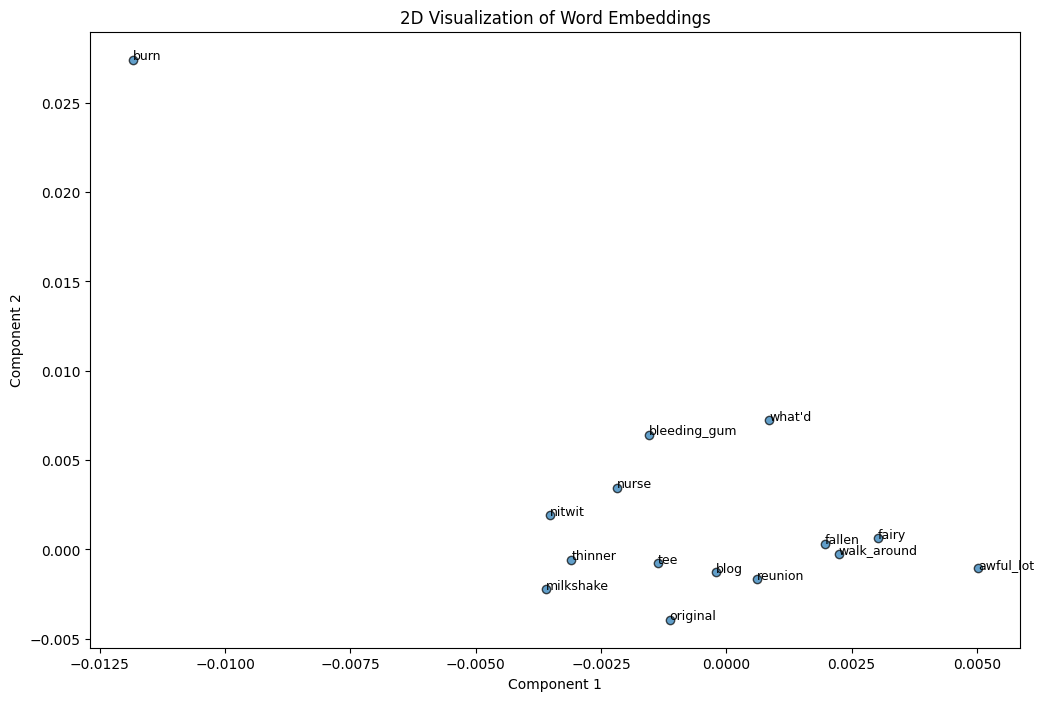

In [ ]:
def visualize_embeddings(embeddings, vocab, dim=2, num_words=100):
    """
    Visualizes word embeddings in 2D or 3D.

    Args:
    - embeddings: Reduced embeddings (numpy array).
    - vocab: List of words corresponding to embeddings.
    - dim: Dimension of visualization (2 or 3).
    - num_words: Number of words to visualize.
    """
    if dim not in [2, 3]:
        raise ValueError("Visualization dimension must be 2 or 3.")

    # TODO: Randomly select a subset of words and their embeddings (≈3 lines)
    random_indices = np.random.choice(len(vocab), size=num_words, replace=False)
    subset_vocab = [vocab[i] for i in random_indices]
    subset_embeddings = embeddings[random_indices]
    if dim == 2:
        df = pd.DataFrame({
            'word': subset_vocab,
            'x': subset_embeddings[:, 0],
            'y': subset_embeddings[:, 1]
        })

        # Plot 2D visualization
        plt.figure(figsize=(12, 8))
        plt.scatter(df['x'], df['y'], alpha=0.7, edgecolors='k')
        for i, word in enumerate(df['word']):
            plt.text(df['x'][i], df['y'][i], word, fontsize=9)
        plt.title('2D Visualization of Word Embeddings')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.show()

    elif dim == 3:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1], subset_embeddings[:, 2], alpha=0.7, edgecolors='k')
        for i, word in enumerate(subset_vocab):
            ax.text(subset_embeddings[i, 0], subset_embeddings[i, 1], subset_embeddings[i, 2], word, fontsize=9)
        ax.set_title('3D Visualization of Word Embeddings')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        plt.show()

visualize_embeddings(reduced_embeddings, vocab, dim=2, num_words=15)

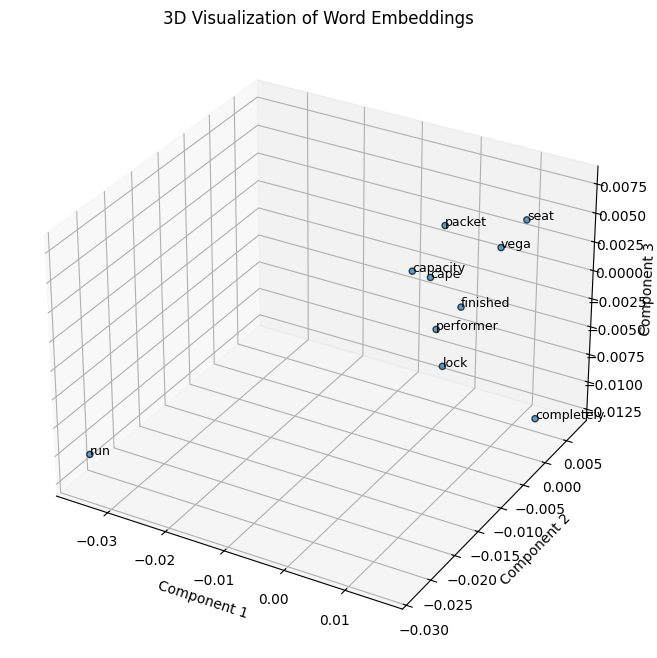

In [ ]:
visualize_embeddings(reduced_embeddings, vocab, dim=3, num_words=10)

### 3.5- Similarity

In this part, we will compute cosine similarity between word embeddings to find words that are semantically similar or dissimilar. Cosine similarity is a measure of similarity between two vectors, calculated by measuring the cosine of the angle between them. A cosine similarity close to 1 indicates high similarity, while a value close to -1 indicates dissimilarity.

1. **get_similar_words**:  
   This function computes the similarity between a given word and all other words in the vocabulary. It returns the top N words most similar to the given word, based on cosine similarity.

2. **get_dissimilar_words**:  
   This function works similarly to `get_similar_words` but returns words that are the most dissimilar to the input word. It finds the top N words that have the lowest cosine similarity to the input word.

3. **get_closest_words_to_vector**:  
   This function finds the closest words to a random vector in the embedding space. It calculates the cosine similarity between the random vector and all word embeddings and returns the top N closest words.

4. **find_analogy**:  
   This function solves word analogies like "king - man + woman = ?" by subtracting the vector of word B from word A and adding the vector of word C. The resulting vector represents the analogy, and the function returns the words closest to this analogy vector.

5. **get_neighbors_of_group**:  
   This function calculates the collective nearest neighbors for a group of words. It averages the word vectors of the given group of words and finds the most similar words to this average vector.

In [ ]:
# Define a function to calculate cosine similarity
def get_similar_words(word, top_n=5, embedding_dim=10):
    """
    Finds similar words based on cosine similarity.

    Args:
    - word: The word to find similarities for.
    - top_n: Number of similar words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with similar words and their similarity scores.
    """
    if word not in word_to_index:
        print(f"Word '{word}' not in vocabulary.")
        return []

    # Get the embedding for the target word
    word_embedding = reduced_embeddings[word_to_index[word]][:embedding_dim]

    # Calculate cosine similarity with all other words
    similarities = cosine_similarity(word_embedding.reshape(1, -1), reduced_embeddings[:, :embedding_dim])

    # Get the indices of the most similar words (excluding the target word itself)
    similar_word_indices = similarities.argsort()[0][-top_n-1:-1][::-1]

    # Get the similar words and their similarity scores
    similar_words = [(vocab[i], similarities[0][i]) for i in similar_word_indices]

    return similar_words

    # TODO: Use the selected dimensions for similarity calculation (≈5 lines)

In [ ]:
# Display some similar words to main characters of simpsons (homer , lisa , bart , ...)
# For example we know homer is lazy and hopeless can embeddings caputure this ?
# Adjust your embedding_dim
word = 'homer'
similar_words_homer = get_similar_words(word, top_n=5)  # Adjust embedding_dim
print(f"Similar words to '{word}': {similar_words_homer}")

Similar words to 'homer': [('homey', 0.8624708762869494), ('protection', 0.8353161463261376), ('tamzarian', 0.827299901978136), ('soul_mate', 0.8206320688358779), ('boiled', 0.8193937662733424)]


In [ ]:
# Checkout lisa
word = 'lisa'
similar_words_lisa = get_similar_words(word, top_n=5)  # Adjust embedding_dim
print(f"Similar words to '{word}': {similar_words_lisa}")

Similar words to 'lisa': [('target', 0.9069606214166952), ('hold_hand', 0.8891771533291171), ('kentucky', 0.869859755466803), ('fracking', 0.8678739022116571), ('cup_coffee', 0.8599693100763353)]


In [ ]:
# What about bart
word = 'bart'
similar_words_bart = get_similar_words(word, top_n=5)  # Adjust embedding_dim
print(f"Similar words to '{word}': {similar_words_bart}")

Similar words to 'bart': [('slight', 0.8783380676231137), ('replacement', 0.8664893066765204), ('huh', 0.8525733409803505), ("talkin'", 0.8455245469096158), ('weigh', 0.8397282772543502)]


In [ ]:
def get_dissimilar_words(word, top_n=5, embedding_dim=10):
    """
    Finds dissimilar words based on cosine similarity.

    Args:
    - word: The word to find dissimilarities for.
    - top_n: Number of dissimilar words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with dissimilar words and their similarity scores.
    """
    # TODO: Use the selected dimensions for similarity calculation (≈5 lines)
    if word not in word_to_index:
        print(f"Word '{word}' not in vocabulary.")
        return []

    # Get the embedding for the target word
    word_embedding = reduced_embeddings[word_to_index[word]][:embedding_dim]

    # Calculate cosine similarity with all other words
    similarities = cosine_similarity(word_embedding.reshape(1, -1), reduced_embeddings[:, :embedding_dim])

    # Get the indices of the most dissimilar words (excluding the target word itself)
    dissimilar_word_indices = similarities.argsort()[0][:top_n]

    # Get the dissimilar words and their similarity scores
    dissimilar_words = [(vocab[i], similarities[0][i]) for i in dissimilar_word_indices]

    return dissimilar_words
# TODO: Find dissimilar words to 'homer' (≈2 line)
word = 'homer'
dissimilar_words_homer = get_dissimilar_words(word, top_n=5, embedding_dim=30)
print(f"Dissimilar words to '{word}': {dissimilar_words_homer}")

Dissimilar words to 'homer': [('hey', -0.6933927763285759), ('hereby', -0.5765668125847625), ('audience', -0.5752611097401245), ('detective', -0.564954027924074), ('beloved', -0.5612933195921099)]


In [ ]:
def get_closest_words_to_vector(vector, top_n=5, embedding_dim=10):
    """
    Finds words closest to a given vector in embedding space.

    Args:
    - vector: A vector (numpy array) to compare against embeddings.
    - top_n: Number of closest words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with closest words and their similarity scores.
    """
    # TODO: find the closest words to the given vector (≈5 lines)

    word_embedding = reduced_embeddings[:,:embedding_dim]
    # print(len(word_embedding[0]))

    reduced_vector = vector[:embedding_dim]
    # print(len(reduced_vector))
    # print(random_vector)
    # print(reduced_vector.reshape(1,-1))
    # Calculate similarities using cosine similarity
    # Get indices of the top N closest words
    # Calculate similarities using cosine_similarity function
    similarities = [cosine_similarity(vector.reshape(1, -1), embedding.reshape(1, -1))[0][0] for embedding in word_embedding]
    # print(similarities)
    # Get indices of the top N closest words
    closest_indices = np.argsort(similarities)[-top_n:][::-1]

    # Create a list of tuples (word, similarity)
    closest_words = [(vocab[idx], similarities[idx]) for idx in closest_indices]

    return closest_words
# TODO: Find closest words to a random vector (≈3 lines)
# are the closest word to random vector similar to each other ?
random_vector = np.random.rand(64)  # Replace with your actual vector
top_n = 5

closest_words_random = get_closest_words_to_vector(random_vector, top_n=top_n, embedding_dim=64)

print("Closest words to random vector:", closest_words_random)

Closest words to random vector: [('approach', 0.43668101099171597), ('nut', 0.42436336470389185), ('den', 0.40986285591773575), ('disgusting', 0.4059502946766061), ('gone', 0.3967776688158844)]


In [ ]:
def find_analogy(word_a, word_b, word_c, top_n=1, embedding_dim=10):
    """
    Solves word analogy: word_a - word_b + word_c = ?

    Args:
    - word_a, word_b, word_c: Words for the analogy equation.
    - top_n: Number of closest words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with the closest words and their similarity scores.
    """
    # TODO: Implement the analogy equation (≈8 lines)
    # Get embeddings for the words
    embedding_a = reduced_embeddings[word_to_index[word_a], :embedding_dim]
    embedding_b = reduced_embeddings[word_to_index[word_b], :embedding_dim]
    embedding_c = reduced_embeddings[word_to_index[word_c], :embedding_dim]

    # Calculate analogy vector
    analogy_vector = embedding_a - embedding_b + embedding_c

    # Find closest words to the analogy vector
    closest_words = get_closest_words_to_vector(analogy_vector, top_n=top_n, embedding_dim=embedding_dim)

    return closest_words

# Let's evaluate if the word embeddings can identify relationships and analogies between words.
analogy_result = find_analogy('bart', 'man', 'woman', top_n=6, embedding_dim=10)
print("Result of analogy 'bart - man + woman':", analogy_result)

Result of analogy 'bart - man + woman': [('long', 0.9084394806700142), ('eco', 0.8879926916785915), ('vacation', 0.8769652443808792), ('term', 0.8594909891404378), ('outsider', 0.8585834187849869), ('connection', 0.8557070415277686)]


In [ ]:
def get_neighbors_of_group(words, top_n=5, embedding_dim=10):
    """
    Finds nearest neighbors for a group of words.

    Args:
    - words: List of words to find collective neighbors for.
    - top_n: Number of neighbors to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with the closest words and their similarity scores.
    """
    # TODO: find the neighbors of the group of words (≈6 lines)
    group_embeddings = [reduced_embeddings[word_to_index[word], :embedding_dim] for word in words if word in word_to_index]

    # Calculate the average embedding for the group
    if group_embeddings:
        average_embedding = np.mean(group_embeddings, axis=0)
    else:
        return []  # Return empty list if no valid words in the group

    # Find closest words to the average embedding
    closest_words = get_closest_words_to_vector(average_embedding, top_n=top_n, embedding_dim=embedding_dim)

    return closest_words


# TODO: Find neighbors of the group ['homer', 'bart'] (≈1 line)
# Find neighbors of the group ['homer', 'bart']
group_neighbors = get_neighbors_of_group(['homer', 'bart'], top_n=5, embedding_dim=10)
print("Neighbors of the group ['homer', 'bart']:", group_neighbors)


Neighbors of the group ['homer', 'bart']: [('soul_mate', 0.8681145370755858), ('saddest', 0.8440118734669058), ('japanese', 0.8288323642755491), ('warning', 0.8286214643755258), ('umm', 0.8252097135670394)]


## 4- Sentiment Analysis of MDB Movie Reviews

In this section, we want to assign a positive/negative lable to a user review for a movie. We will use LSTM, a version of RNN, to process the embeddings. We use the previous embeddings for this section. Let's dive in!

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import re
from tqdm import tqdm

### 4.1- Dataset

Here we load the dataset. the dataset consists of $5000$ reviews (the original dataset has $50000$ rows, for time constraints, we just use the first $5000$ rows of reviews) with their sentiment ,positive or negative.

In [ ]:
root_path = '/content/drive/My Drive/Colab Notebooks'
# Change this to the root path of your dataset
df = pd.read_csv(f'{root_path}/IMDB Dataset_small.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
4995,An interesting slasher film with multiple susp...,negative
4996,i watched this series when it first came out i...,positive
4997,Once again Jet Li brings his charismatic prese...,positive
4998,"I rented this movie, after hearing Chris Gore ...",negative


First, let's remove unnecessary words from each review. And also map the sentiment to numerical binary values.

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

# Apply the preprocessing function to the 'review' column
df['review'] = df['review'].apply(preprocess_string)

# Make the 'sentiment' column numerical
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production br br The filmin...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
4995,An interesting slasher film with multiple susp...,0
4996,i watched this series when it first came out i...,1
4997,Once again Jet Li brings his charismatic prese...,1
4998,I rented this movie after hearing Chris Gore s...,0


Plot the histogram of reviews lengths.

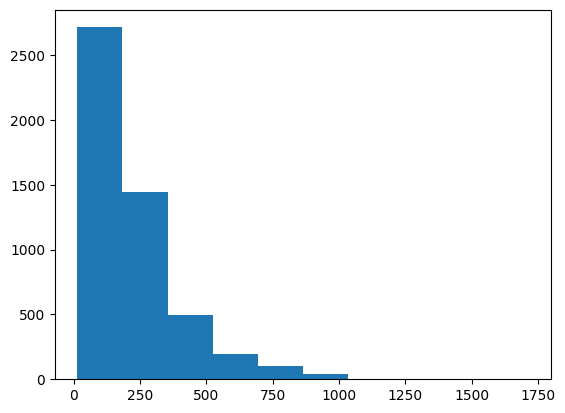

In [ ]:
# TODO: Plot the histogram of review lengths (number of words) (≈2 line)
plt.figure()
plt.hist([len(review.split()) for review in df['review']], bins=10)
plt.show()

Write the tokenize function to tokenize each word. You can use your previous vocabulary. This cell will take about $2$ minutes.

In [ ]:
vocabulary = {word: idx for idx, word in enumerate(vocab)}

def _tokenize(s):
    """Tokenizes the input string and retains words found in the vocabulary."""
    return [vocabulary[word] for word in s.split() if word in vocabulary]

# TODO: Tokenize the reviews (≈1 line)
X = df['review'].apply(_tokenize).values
X = pd.DataFrame(X.tolist(), index=df.index)  # Convert to DataFrame
X=pd.DataFrame({'reviews': X.values.tolist()})
X

,reviews
0,"[4980.0, 966.0, 4690.0, 3056.0, 65.0, 2369.0, ..."
1,"[341.0, 0.0, 1427.0, 5341.0, 1.0, 286.0, 2001...."
2,"[28.0, 341.0, 74.0, 994.0, 199.0, 771.0, 4274...."
3,"[1172.0, 0.0, 539.0, 2647.0, 3280.0, 354.0, 17..."
4,"[2286.0, 1393.0, 5144.0, 4963.0, 1154.0, 1721...."
...,...
4995,"[1650.0, 2286.0, 5765.0, 66.0, 2369.0, 6077.0,..."
4996,"[3395.0, 4935.0, 229.0, 706.0, 3727.0, 1487.0,..."
4997,"[563.0, 2105.0, 1721.0, 2556.0, 2286.0, 2286.0..."
4998,"[4750.0, 1721.0, 1455.0, 163.0, 767.0, 2423.0,..."


[link text](https://)Pad the sentences to a fixed size $512$. If they are longer, truncate them.

In [ ]:
import math
def padding_(sentences, seq_len):
    # TODO: Implement the padding function (≈5 lines)
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, review in enumerate(sentences):
        if len(review) != 0:
            # Filter out NaN values and convert to integers
            valid_tokens = [int(token) for token in review if not math.isnan(token)]

            if len(valid_tokens) > 0:  # Check if there are valid tokens
                review = valid_tokens
                if len(review) <= seq_len:  # Pad if shorter
                    features[i, -len(review):] = review[:seq_len]
                else:  # Truncate if longer
                    features[i, :] = review[:seq_len]
    return features
X = padding_(X['reviews'].to_list(), 512)


In [ ]:
# TODO: Define the labels y (≈1 line)
y = df['sentiment']
assert X.shape == (5000, 512) and y.shape == (5000,)


Use `reduced_embeddings` from the previous section to make the input in shape $N \times L \times D$, where $N=5000$ is the number of the rows, $L=512$ is the sequence length for each review, and $D=64$ is the dimension of embeddings after SVD.

In [ ]:
# TODO: Use the previous embeddings to create the embedding matrix (≈1 line)
embedding_matrix = reduced_embeddings

# Reshape X to be N x L x D
# We need to create a new array to hold the embeddings
N, L, D = 5000, 512, 64
X_embeddings = np.zeros((N, L, D), dtype=float)

# Populate the embedding matrix for each review
for i in range(N):
    for j in range(min(L, X.shape[1])):  # Limit j to the number of columns in X
        token_index = X[i, j]
        token_index = int(token_index)

        if token_index < reduced_embeddings.shape[0]:  # Ensure index is within bounds
            X_embeddings[i, j] = embedding_matrix[token_index]

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(f'Shape of X_embeddings: {X_embeddings.shape}')
X=X_embeddings

Shape of X: (5000, 512)
Shape of y: (5000,)
Shape of X_embeddings: (5000, 512, 64)


In this part split the dataset into train and validation sets. Use [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to create batches of the input data.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)} | Validation size: {len(X_val)}")

Train size: 4000 | Validation size: 1000


In [ ]:
# TODO: Create Tensor datasets (≈2 lines)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
batch_size = 50

# TODO: Define the DataLoaders (≈2 lines)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")

Number of training batches: 80
Number of validation batches: 20


The bellow cell is to get familiar with dataloaders.

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input x shape:', sample_x.shape)
print('Sample input y shape:', sample_y.shape)

Sample input x shape: torch.Size([50, 512, 64])
Sample input y shape: torch.Size([50])


[link text](https://)You may need GPU for faster training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 4.2- Model

In this part, you are supposed to implement key components of a recurrent neural network (RNN) for sentiment analysis using **PyTorch**. Initialize the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) using `nn` in torch, and a fully connected layer.

You just need to implement the forward pass of the model. PyTorch will calculate the gradients automatically (we will see how) and do backpropagation for us, which makes dealing with complex models super easier.

LSTM has two hiddens, for simplicity initialize them to zero vectors.

In [ ]:
# class SentimentRNN(nn.Module):
#     def __init__(self, n_layers, hidden_dim, embedding_dim):
#         super(SentimentRNN,self).__init__()
#         # TODO: Define the model layers (≈5 lines)
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix.copy()))
#         self.embedding.weight.requires_grad = False  # Freeze embeddings
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid()
#         self.n_layers = n_layers
#         self.hidden_dim = hidden_dim
#     def forward(self, x, hidden):
#         """
#         Feed x to lstm, then pass the output to the fully connected layer, followed by sigmoid.
#         Use the last output of the sequence for classification
#         """
#         batch_size = x.size(0)

#         embeds = self.embedding(x)
#         lstm_out, hidden = self.lstm(embeds, hidden)

#         lstm_out = lstm_out[:, -1, :]  # Get the last output of the LSTM

#         out = self.fc(lstm_out)
#         sig_out = self.sigmoid(out)

#         # Squeeze the output to remove the extra dimension
#         sig_out = sig_out.squeeze(1)  # Change shape from (batch_size, 1) to (batch_size)

#         return sig_out, hidden  # Return the squeezed output

#     def init_hidden(self, batch_size, device):
#         ''' Initializes hidden state '''
#         # TODO: Create two new tensors with sizes n_layers x batch_size x hidden_dim,
#         # initialized to zero, for hidden state and cell state of LSTM (≈2 lines)
#         h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
#         c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
#         hidden = (h0, c0)
#         return hidden
class SentimentRNN(nn.Module):
    def __init__(self, n_layers, hidden_dim, embedding_dim, vocab_size, embedding_matrix):
        super(SentimentRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix.copy()))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, x, hidden):
        batch_size = x.size(0)
        # print(f"Input shape before embedding: {x.shape}")  # Debug print

        embeds = self.embedding(x)
        # print(f"After embedding: {embeds.shape}")  # Should be (batch_size, seq_length, embedding_dim)

        lstm_out, hidden = self.lstm(embeds, hidden)
        # print(f"After LSTM: {lstm_out.shape}")  # Should be (batch_size, seq_length, hidden_dim)

        lstm_out = lstm_out[:, -1, :]  # Get the last output of LSTM
        # print(f"After selecting last output: {lstm_out.shape}")  # Should be (batch_size, hidden_dim)

        out = self.fc(lstm_out)
        sig_out = self.sigmoid(out)

        sig_out = sig_out.squeeze(1)  # Remove extra dimension

        return sig_out, hidden

    def init_hidden(self, batch_size, device):
        ''' Initializes hidden state '''
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)


In [ ]:
# n_layers = 3
# embedding_dim = 64
# hidden_dim = 128

# model = SentimentRNN(n_layers, hidden_dim, embedding_dim)
# model.to(device)
n_layers = 3
embedding_dim = 64
hidden_dim = 128
vocab_size = 5000  # Example vocab size
embedding_matrix = np.random.rand(vocab_size, embedding_dim)  # Dummy embedding matrix

# Initialize Model
model = SentimentRNN(n_layers, hidden_dim, embedding_dim, vocab_size, embedding_matrix)
model.to(device)

SentimentRNN(
  (embedding): Embedding(5000, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
example_input = torch.randint(0, vocab_size, (50, 512), device=device)
hidden = model.init_hidden(50, device)
output, hidden = model(example_input, hidden)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([50])


### 4.3- Train

Use [BCE](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) for loss function. [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is another optimizer that similar to Gradient Descent, its main idea is taking step on the opposite side of the gradients. We will need `acc` function to evaluate our model on unseen data.

In [ ]:
# lr = 0.0003
# # TODO: Define the loss function and the optimizer (≈2 lines)
# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
# def acc(pred: torch.Tensor, label: torch.Tensor) -> int:
#     # TODO: Calculate the accuracy of the model (≈2 line)
#     # Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
#     predicted = (pred > 0.5).float()

#     # Compare predicted labels with true labels and calculate accuracy
#     correct = (predicted == label).sum().item()
#     total = label.size(0)
#     accuracy = correct / total

#     return accuracy
lr = 0.0003
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ------------------------
# Accuracy Function
# ------------------------
def acc(pred: torch.Tensor, label: torch.Tensor) -> float:
    predicted = (pred > 0.5).float()
    correct = (predicted == label).sum().item()
    total = label.size(0)
    return correct / total

This [blog](https://pytorch.org/blog/overview-of-pytorch-autograd-engine/) explains how PyTorch computes gradients. Basically, the main core of it is using chain rule. It stores all the basic derivatives in [derivatives](https://github.com/pytorch/pytorch/blob/a0a7a2d648f05b0192e6943c9684406cdf404fbf/tools/autograd/derivatives.yaml#L635-L636), then for every possible function, PyTorch breaks them down to basic functions which the derivatives are known.

We now train our model using this powerful library. See [this](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) if you need more information about how optimization works in PyTorch. We use gradient clipping, whihc might be helpful for RNNs.

In [ ]:
# epochs = 10
# valid_loss_min = np.Inf
# clip = 5

# epoch_tr_loss, epoch_vl_loss = [], []
# epoch_tr_acc, epoch_vl_acc = [], []

# for epoch in range(epochs):
#     train_losses = []
#     train_acc = 0.0
#     model.train()
#     h = model.init_hidden(batch_size, device)  # Initialize hidden state
#     for inputs, labels in tqdm(train_loader, total=len(train_loader)):
#         inputs = inputs.type(torch.LongTensor).to(device)
#         inputs = inputs.squeeze(1)  # Ensure correct shape

#         # inputs, labels = inputs.to(device), labels.to(device)
#         # inputs = inputs.type(torch.LongTensor).to(device)  # or torch.int64

#         h = tuple([each.data for each in h])  # Detach hidden state

#         # Training steps
#         optimizer.zero_grad()  # Zero out gradients
#         output, h = model(inputs, h)  # Forward pass
#         loss = criterion(output.squeeze(), labels.float())  # Calculate loss
#         loss.backward()  # Backpropagate

#         nn.utils.clip_grad_norm_(model.parameters(), clip)  # Clip gradients
#         optimizer.step()  # Update weights

#         train_losses.append(loss.item())  # Record loss
#         train_acc += acc(output, labels)  # Accumulate accuracy

#     # Validation
#     val_h = model.init_hidden(batch_size, device)
#     val_losses = []
#     val_acc = 0.0
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in valid_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             output, val_h = model(inputs, val_h)
#             val_loss = criterion(output.squeeze(), labels.float())
#             val_losses.append(val_loss.item())
#             val_acc += acc(output, labels)

#     # Epoch statistics
#     epoch_train_loss = np.mean(train_losses)
#     epoch_val_loss = np.mean(val_losses)
#     epoch_train_acc = train_acc / len(train_loader)  # Calculate average training accuracy
#     epoch_val_acc = val_acc / len(valid_loader)    # Calculate average validation accuracy

#     epoch_tr_loss.append(epoch_train_loss)
#     epoch_vl_loss.append(epoch_val_loss)
#     epoch_tr_acc.append(epoch_train_acc)
#     epoch_vl_acc.append(epoch_val_acc)

#     print(f'Epoch {epoch+1}: | Train Loss: {epoch_train_loss:.3f} | Val Loss: {epoch_val_loss:.3f} | Train Acc: {epoch_train_acc:.3f}| Val Acc: {epoch_val_acc:.3f}')

#     # Save model if validation loss decreases
#     if epoch_val_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
#         torch.save(model.state_dict(), 'state_dict.pt')
#         valid_loss_min = epoch_val_loss
epochs = 10
valid_loss_min = np.Inf
clip = 5

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    h = model.init_hidden(batch_size, device)  # Initialize hidden state

    for inputs, labels in tqdm(train_loader, total=len(train_loader)):
        # print(f"Raw labels from DataLoader: {labels}")
        # print(f"Any NaNs? {torch.isnan(labels).any().item()}")
        inputs, labels = inputs.to(device), labels.to(device)
        # print(f"Unique label values: {labels.unique()}")  # Check label distribution
    # Ensure input is of shape (batch_size, seq_len)
        if inputs.dim() == 3:  # If shape is (batch_size, seq_len, embedding_dim)
            inputs = inputs.argmax(-1)  # Convert back to token indices (batch_size, seq_len)

        # print(f"Train Batch Shape (Before Model): {inputs.shape}")  # Debugging
        h = tuple([each.data for each in h])  # Detach hidden state
        # print(f"Before processing, labels contain NaN: {torch.isnan(labels).any().item()}")

        # print(f"Label values before fixing: {labels}")

        optimizer.zero_grad()
        inputs = inputs.squeeze(1).long().to(device)
        # print('input type:',inputs.dtype)  # Should print torch.long
        output, h = model(inputs, h)  # Forward pass

        loss = criterion(output.squeeze(), labels.float())  # Convert labels to float

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


        train_losses.append(loss.item())
        train_acc += acc(output, labels)

    # ------------------------
    # Validation Step
    # ------------------------
    val_h = tuple(t.to(device) for t in model.init_hidden(batch_size, device))
    val_losses = []
    val_acc = 0.0
    model.eval()

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(1).long().to(device)
            if inputs.dim() == 3:  # If shape is (batch_size, seq_len, embedding_dim)
              inputs = inputs.argmax(-1)
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())
            val_losses.append(val_loss.item())
            val_acc += acc(output, labels)

    # Compute epoch statistics
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader)
    epoch_val_acc = val_acc / len(valid_loader)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}: | Train Loss: {epoch_train_loss:.3f} | Val Loss: {epoch_val_loss:.3f} | Train Acc: {epoch_train_acc:.3f}| Val Acc: {epoch_val_acc:.3f}')

    # Save model if validation loss decreasess
    if epoch_val_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {epoch_val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'state_dict.pt')
        valid_loss_min = epoch_val_loss

100%|██████████| 80/80 [00:03<00:00, 20.69it/s]


Epoch 1: | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 0.507| Val Acc: 0.530
Validation loss decreased (inf --> 0.692690). Saving model...


100%|██████████| 80/80 [00:02<00:00, 26.99it/s]


Epoch 2: | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 0.506| Val Acc: 0.470


100%|██████████| 80/80 [00:02<00:00, 28.90it/s]


Epoch 3: | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 0.501| Val Acc: 0.530
Validation loss decreased (0.692690 --> 0.692065). Saving model...


100%|██████████| 80/80 [00:02<00:00, 29.15it/s]


Epoch 4: | Train Loss: 0.692 | Val Loss: 0.694 | Train Acc: 0.511| Val Acc: 0.470


100%|██████████| 80/80 [00:02<00:00, 29.03it/s]


Epoch 5: | Train Loss: 0.689 | Val Loss: 0.693 | Train Acc: 0.544| Val Acc: 0.530


100%|██████████| 80/80 [00:02<00:00, 27.97it/s]


Epoch 6: | Train Loss: 0.683 | Val Loss: 0.697 | Train Acc: 0.553| Val Acc: 0.470


100%|██████████| 80/80 [00:02<00:00, 26.97it/s]


Epoch 7: | Train Loss: 0.668 | Val Loss: 0.699 | Train Acc: 0.583| Val Acc: 0.470


100%|██████████| 80/80 [00:02<00:00, 27.51it/s]


Epoch 8: | Train Loss: 0.662 | Val Loss: 0.699 | Train Acc: 0.603| Val Acc: 0.470


100%|██████████| 80/80 [00:02<00:00, 28.16it/s]


Epoch 9: | Train Loss: 0.649 | Val Loss: 0.703 | Train Acc: 0.619| Val Acc: 0.470


100%|██████████| 80/80 [00:02<00:00, 28.26it/s]


Epoch 10: | Train Loss: 0.646 | Val Loss: 0.695 | Train Acc: 0.625| Val Acc: 0.530


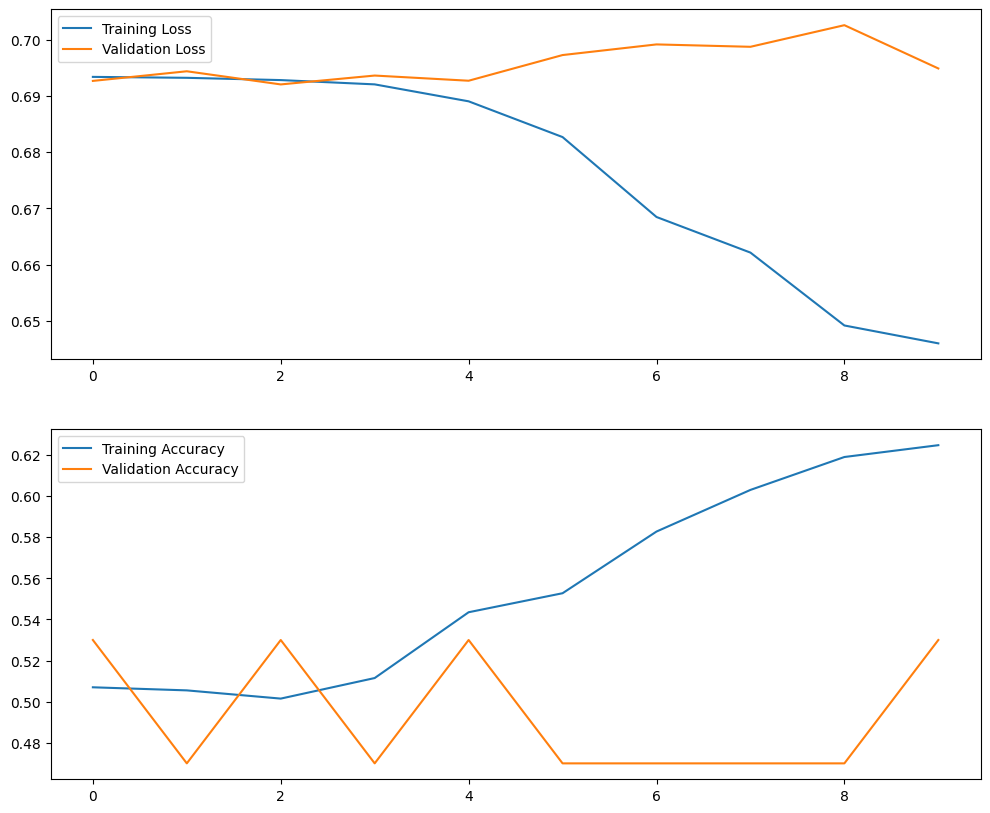

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(epoch_tr_loss, label='Training Loss')
ax1.plot(epoch_vl_loss, label='Validation Loss')
ax1.legend()
ax2.plot(epoch_tr_acc, label='Training Accuracy')
ax2.plot(epoch_vl_acc, label='Validation Accuracy')
ax2.legend()

plt.show()